<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Future_work/qaoa_maxcut_qng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.5 MB/s eta 0:00:00


QAOA for MaxCut {#qaoa_maxcut}
===============

::: {.meta}
:property=\"og:description\": Implementing the quantum approximate
optimization algorithm using PennyLane to solve the MaxCut problem.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//qaoa_maxcut_partition.png>
:::

::: {.related}
tutorial\_qaoa\_intro Intro to QAOA
:::

*Author: Angus Lowe --- Posted: 11 October 2019. Last updated: 13 April
2021.*


In this tutorial we implement the quantum approximate optimization
algorithm (QAOA) for the MaxCut problem as proposed by [Farhi,
Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028). First,
we give an overview of the MaxCut problem using a simple example, a
graph with 4 vertices and 4 edges. We then show how to find the maximum
cut by running the QAOA algorithm using PennyLane.

Background
==========

The MaxCut problem
------------------

The aim of MaxCut is to maximize the number of edges (yellow lines) in a
graph that are \"cut\" by a given partition of the vertices (blue
circles) into two sets (see figure below).

![](https://github.com/borbysh/Momentum-QNG/blob/_static/demonstration_assets/qaoa_maxcut/qaoa_maxcut_partition.png?raw=1){.align-center}

|

Consider a graph with $m$ edges and $n$ vertices. We seek the partition
$z$ of the vertices into two sets $A$ and $B$ which maximizes

$$C(z) = \sum_{\alpha=1}^{m}C_\alpha(z),$$

where $C$ counts the number of edges cut. $C_\alpha(z)=1$ if $z$ places
one vertex from the $\alpha^\text{th}$ edge in set $A$ and the other in
set $B$, and $C_\alpha(z)=0$ otherwise. Finding a cut which yields the
maximum possible value of $C$ is an NP-complete problem, so our best
hope for a polynomial-time algorithm lies in an approximate
optimization. In the case of MaxCut, this means finding a partition $z$
which yields a value for $C(z)$ that is close to the maximum possible
value.

We can represent the assignment of vertices to set $A$ or $B$ using a
bitstring, $z=z_1...z_n$ where $z_i=0$ if the $i^\text{th}$ vertex is in
$A$ and $z_i = 1$ if it is in $B$. For instance, in the situation
depicted in the figure above the bitstring representation is
$z=0101\text{,}$ indicating that the $0^{\text{th}}$ and $2^{\text{nd}}$
vertices are in $A$ while the $1^{\text{st}}$ and $3^{\text{rd}}$ are in
$B$. This assignment yields a value for the objective function (the
number of yellow lines cut) $C=4$, which turns out to be the maximum
cut. In the following sections, we will represent partitions using
computational basis states and use PennyLane to rediscover this maximum
cut.

::: {.note}
::: {.title}
Note
:::

In the graph above, $z=1010$ could equally well serve as the maximum
cut.
:::

A circuit for QAOA
------------------

This section describes implementing a circuit for QAOA using basic
unitary gates to find approximate solutions to the MaxCut problem.
Firstly, denoting the partitions using computational basis states
$|z\rangle$, we can represent the terms in the objective function as
operators acting on these states

$$C_\alpha = \frac{1}{2}\left(1-\sigma_{z}^j\sigma_{z}^k\right),$$

where the $\alpha\text{th}$ edge is between vertices $(j,k)$. $C_\alpha$
has eigenvalue 1 if and only if the $j\text{th}$ and $k\text{th}$ qubits
have different z-axis measurement values, representing separate
partitions. The objective function $C$ can be considered a diagonal
operator with integer eigenvalues.

QAOA starts with a uniform superposition over the $n$ bitstring basis
states,

$$|+_{n}\rangle = \frac{1}{\sqrt{2^n}}\sum_{z\in \{0,1\}^n} |z\rangle.$$

We aim to explore the space of bitstring states for a superposition
which is likely to yield a large value for the $C$ operator upon
performing a measurement in the computational basis. Using the $2p$
angle parameters $\boldsymbol{\gamma} = \gamma_1\gamma_2...\gamma_p$,
$\boldsymbol{\beta} = \beta_1\beta_2...\beta_p$ we perform a sequence of
operations on our initial state:

$$|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle = U_{B_p}U_{C_p}U_{B_{p-1}}U_{C_{p-1}}...U_{B_1}U_{C_1}|+_n\rangle$$

where the operators have the explicit forms

$$\begin{aligned}
U_{B_l} &= e^{-i\beta_lB} = \prod_{j=1}^n e^{-i\beta_l\sigma_x^j}, \\
U_{C_l} &= e^{-i\gamma_lC} = \prod_{\text{edge (j,k)}} e^{-i\gamma_l(1-\sigma_z^j\sigma_z^k)/2}.
\end{aligned}$$

In other words, we make $p$ layers of parametrized $U_bU_C$ gates. These
can be implemented on a quantum circuit using the gates depicted below,
up to an irrelevant constant that gets absorbed into the parameters.

![](https://github.com/borbysh/Momentum-QNG/blob/_static/demonstration_assets/qaoa_maxcut/qaoa_operators.png?raw=1){.align-center}

|

Let $\langle \boldsymbol{\gamma},
\boldsymbol{\beta} | C | \boldsymbol{\gamma},\boldsymbol{\beta} \rangle$
be the expectation of the objective operator. In the next section, we
will use PennyLane to perform classical optimization over the circuit
parameters $(\boldsymbol{\gamma}, \boldsymbol{\beta})$. This will
specify a state $|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle$ which
is likely to yield an approximately optimal partition $|z\rangle$ upon
performing a measurement in the computational basis. In the case of the
graph shown above, we want to measure either 0101 or 1010 from our state
since these correspond to the optimal partitions.

![](https://github.com/borbysh/Momentum-QNG/blob/_static/demonstration_assets/qaoa_maxcut/qaoa_optimal_state.png?raw=1){.align-center}

|

Qualitatively, QAOA tries to evolve the initial state into the plane of
the $|0101\rangle$, $|1010\rangle$ basis states (see figure above).

Implementing QAOA in PennyLane
==============================

Imports and setup
-----------------

To get started, we import PennyLane along with the PennyLane-provided
version of NumPy.


In [2]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

Operators
=========

We specify the number of qubits (vertices) with `n_wires` and compose
the unitary operators using the definitions above. $U_B$ operators act
on individual wires, while $U_C$ operators act on wires whose
corresponding vertices are joined by an edge in the graph. We also
define the graph using the list `graph`, which contains the tuples of
vertices defining each edge in the graph.


In [3]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
ZZ = []
ZZ_coeff = []
for k in range(len(graph)):
  edge = graph[k]
  ZZ.append(qml.PauliZ(edge[0])@qml.PauliZ(edge[1]))
  ZZ_coeff.append(1)
C = len(graph)
H = qml.Hamiltonian(ZZ_coeff, ZZ, grouping_type="qwc")


# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

We will need a way to convert a bitstring, representing a sample of
multiple qubits in the computational basis, to integer or base-10 form.


In [4]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

Circuit
=======

Next, we create a quantum device with 4 qubits.


In [5]:
dev = qml.device("lightning.qubit", wires=n_wires)

We also require a quantum node which will apply the operators according
to the angle parameters, and return the expectation value of the
observable $\sigma_z^{j}\sigma_z^{k}$ to be used in each term of the
objective function later on. The argument `edge` specifies the chosen
edge term in the objective function, $(j,k)$. Once optimized, the same
quantum node can be used for sampling an approximately optimal bitstring
if executed with the `edge` keyword set to `None`. Additionally, we
specify the number of layers (repeated applications of $U_BU_C$) using
the keyword `n_layers`.


In [6]:
# Design the ansatz
p = 2     # circuit repetitions
def ansatz(params, qubits, depth=p):
  for wire in range(qubits):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
  for i in range(len(params)//2):
      U_C(params[2*i])
      U_B(params[2*i+1])

In [7]:
# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x):
    ansatz(x, qubits=n_wires)
    return qml.expval(H)

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=n_wires)
    return qml.probs(wires=range(n_wires))

In [8]:
def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      qng_cost.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 4) == np.round(obj_value, 4):
              break
          else:
              old_cost = obj_value
  return params

In [9]:
def momentum_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      momentum_cost.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 4) == np.round(obj_value, 4):
              break
          else:
              old_cost = obj_value
  return params

In [10]:
def momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  prev_step = params * 0

  for i in range(steps):
        prev_params = params
        params = opt.step(cost, params) + momentum * prev_step
        prev_step = params - prev_params
        obj_value = cost(params)
        momentum_qng_cost.append(obj_value)
        if (i + 1) % 5 == 0:
            #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
            if np.round(old_cost, 4) == np.round(obj_value, 4):
                break
            else:
                old_cost = obj_value
  return params

In [11]:
def new_momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumQNGOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      new_momentum_qng_cost.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 4) == np.round(obj_value, 4):
              break
          else:
              old_cost = obj_value
  return params

In [12]:
iterations=300
stepsize = 0.02
momentum=0.9

qng_cost = []
momentum_qng_cost = []
new_momentum_qng_cost = []
momentum_cost = []
#np.random.seed(31415)
#np.random.seed()
np.random.seed(1)
init_params = np.random.rand(2*p)

params_qng = qng_session(init_params, stepsize, iterations)
params_momentum_qng = momentum_qng_session(init_params, stepsize, momentum, iterations)
params_new_momentum_qng = new_momentum_qng_session(init_params, stepsize, momentum, iterations)
params_momentum = momentum_session(init_params, stepsize, momentum, iterations)
cost_qng = cost(params_qng)
cost_momentum_qng = cost(params_momentum_qng)
cost_new_momentum_qng = cost(params_new_momentum_qng)

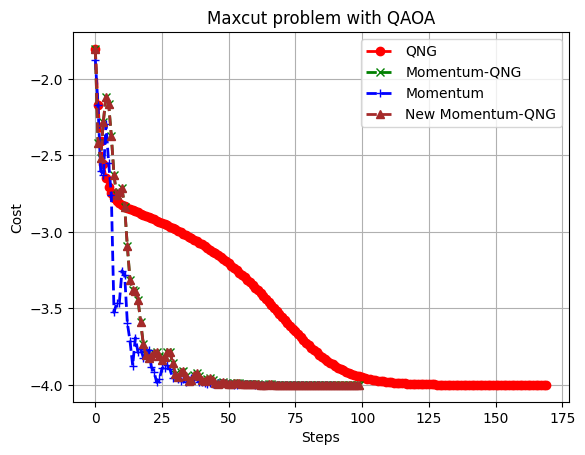

In [14]:
import matplotlib.pyplot as plt

label_1 = 'QNG'
label_2 = 'Momentum-QNG'
label_3 = 'Momentum'
label_4 = 'New Momentum-QNG'
plt.plot(qng_cost, color='r', marker='o', linestyle='--', linewidth = 2.0, label=label_1)
plt.plot(momentum_qng_cost, color='g', marker='x', linestyle='--', linewidth = 2.0, label=label_2)
plt.plot(momentum_cost, color='b', marker='+', linestyle='--', linewidth = 2.0, label=label_3)
plt.plot(new_momentum_qng_cost, color='brown', marker='^', linestyle='--', linewidth = 2.0, label=label_4)


plt.title('Maxcut problem with QAOA')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.grid()

plt.show()